# De-gending text

Steps:
1. Load data for each different corpus into consistent format
    - Enron
    - X RtGender
2. X Train-Dev-Test Split on all of them
3. X Build TF-IDF vectorizors on all training datasets
4. X Build gender classifiers on all training datasets
5. Use a count-vectorizer to build the Delete Procedure
    - One vectorizer for each (male/female)
    - Use this to create a dict mapping each word to its count value
    - Lambda = 1; gamma = 5 (to start)
    - Then use a function to look up the count ratio for each word given a sentence
6. Make a similarity function - TF-IDF weighted word overlap between sentences.
    - Maybe pairwise pre-compute this for all combos?
7. Make Retrieve functions
    - First one that retrieves the most similar sentence in the target attribute
    - Next one that gets the top few sentences, and replaces the attributes in the source sentence one at a time with attributes in the target sentence(s)
    
Experiments:
1. Do each of these individually, end-to-end
2. Do each combination of applying different de-gendering systems to each other dataset. Apply the datasets trained gender classifier, and look at drop in acc, F1, and change in confusion matrix vs. before

In [1]:
%load_ext autoreload
%autoreload 2

In [89]:
# Local imports
from dataset import Dataset

In [96]:
PATH = 'data/rt_gender/'
fitocracy = Dataset('fitocracy_responses', PATH)

Loading the dataset...
Cleaning data...
Making data splits...
Training the vectorizer...
Transforming the vectors...


C:\Users\Alex\Documents\School\Fall 2018\independent_study\dataset.py:133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.splits.test['label_col'] = test_labels


Training a base classifier...
Done initializing fitocracy_responses dataset!


# TODO
- X Get the counts for each word (naive-bayes counts)
    - Transform into logspace
- Set a gamma threshold
- For each sentence, split into context, attributes by this threshold

In [141]:
from dataset import TransformedDataset

 75%|███████████████████████████████████████████████████████▎                  | 97587/130623 [03:50<01:05, 505.51it/s]

In [ ]:
t_dataset = TransformedDataset(fitocracy, 2, 1, wc_df)

# Evaluating baseline performance

In [5]:
from sklearn.metrics import classification_report, accuracy_score

In [6]:
train_pred = fitocracy.clf.predict(fitocracy.vecs.train)
dev_pred = fitocracy.clf.predict(fitocracy.vecs.dev)

In [7]:
print(classification_report(fitocracy.labels.train, train_pred))

             precision    recall  f1-score   support

          0       0.64      0.77      0.70    124204
          1       0.73      0.58      0.65    130623

avg / total       0.69      0.68      0.67    254827



In [8]:
print(classification_report(fitocracy.labels.dev, dev_pred))

             precision    recall  f1-score   support

          0       0.63      0.76      0.69     15518
          1       0.72      0.58      0.64     16336

avg / total       0.68      0.67      0.67     31854



# Building the count vectorizer

In [9]:
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [10]:
lambd = 1

In [11]:
# Split male/female
male_df = fitocracy.df[fitocracy.df['responder_gender'] == 'M']
female_df = fitocracy.df[fitocracy.df['responder_gender'] == 'W']

In [12]:
male_count_vectorizer = CountVectorizer(min_df=10).fit(male_df['response_text'])
female_count_vectorizer = CountVectorizer(min_df=10).fit(female_df['response_text'])

In [13]:
m_word_counts = np.array(male_count_vectorizer.transform(
    [' '.join(male_df['response_text'])]).todense())[0]
f_word_counts = np.array(female_count_vectorizer.transform(
    [' '.join(female_df['response_text'])]).todense())[0]

In [14]:
m_features = male_count_vectorizer.get_feature_names()
f_features = female_count_vectorizer.get_feature_names()

In [16]:
f_df = pd.DataFrame(f_word_counts, index=f_features, columns=['female_count'])
m_df = pd.DataFrame(m_word_counts, index=m_features, columns=['male_count'])
full_df = pd.concat([f_df, m_df], axis=1)
full_df.fillna(0, inplace=True)
full_df['female_ratio'] = ((full_df['female_count'] + lambd) /
                    (full_df['male_count'] + lambd))
full_df['male_ratio'] = ((full_df['male_count'] + lambd) /
                    (full_df['female_count'] + lambd))

In [17]:
word_set = set(full_df.index)

# Determining which words to replace

Given a sentence score each word, and if it is above gamma in favor of the current gender

In [18]:
gamma = 5

In [19]:
def score_words(row):
    text = row['response_text']
    gender = row['responder_gender']
    gender_col = 'female_ratio' if gender=='W' else 'male_ratio'
    
    vals = []
    
    for word in text.lower().split(' '):
        if word in word_set:
            val = full_df[gender_col][word]
            vals.append(val)
        else:
            vals.append(-1)
    return vals

In [20]:
score_words(fitocracy.df.iloc[0])

[1.3096895074946466, 1.2269881026925484, 1.3949491406524026, -1, -1, -1]

In [21]:
word_vecs = [score_words(row) for i, row in male_df[:10_000].iterrows()]

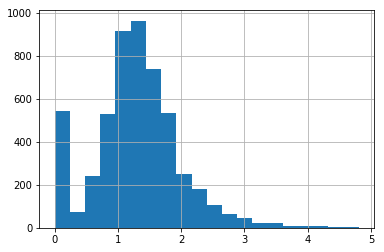

In [26]:
full_df[full_df['male_ratio'] < 5]['male_ratio'].hist(bins=20)
plt.show()

# Replace some of these words

In [186]:
m_df_subset = male_df[:10_000]

In [187]:
# For now just sample a random word that biases male
sentences = [text.split(' ') for text in m_df_subset['response_text']]

In [188]:
male_sampler = full_df[full_df['male_ratio'] > 1]
female_sampler = full_df[full_df['female_ratio'] > 1]

def get_random_word(gender):
    if gender == 'male':
        return male_sampler.sample(1).index[0]
    else:
        return female_sampler.sample(1).index[0]

In [189]:
from tqdm import tqdm, tqdm_notebook

In [190]:
n_words_seen = 0
n_words_changed = 0

for sent, vals in tqdm_notebook(zip(sentences, word_vecs)):
    for i, val in enumerate(vals):
        n_words_seen += 1
        if val > 1.2:
            n_words_changed += 1
            sent[i] = get_random_word('female')

A Jupyter Widget

In [191]:
print(n_words_changed, '/', n_words_seen)

49895 / 132025


In [161]:
print(n_words_changed, '/', n_words_seen)

29860 / 133551


In [192]:
transformed_sentences = [' '.join(sent) for sent in sentences]

In [193]:
transformed_sentences[:15]

['letter recomp netflix a time! =]',
 'You can books daaaawh pullups. downloaded feeling refuse you qualified would. spinning the hangover of exchange and wow completed. nerves the bottom of the "pull-up" introducing section, slept "advanced options". You may cheer psh stairs pittsburgh or pink counting "type" and the anytime wishes used.',
 'Hey! I ly started a new job, so things memory flattered hectic. cough me amazingly skates to you with a accomplishments answer.',
 'curse lifting, HAES?',
 "ooooh slept user cracks I'll women stalked to terribly to compete, create I'll cheese spectating (for $7 iirc).",
 '+1 for ear marijuanaWhen you outlaw medicine, quotes criminals unhealthy have medicine.',
 'debating for cereal beaches portioning alive',
 'interact of us, tags of practically . . .',
 "terry is my favorite holiday of the year. I've been giddy all week. I've been yayyyy the ole commute out with xoxoxo to counteract the escape effect.",
 "boards abilities lol awesome. I'm too tub

# Now compare the prediction on these changes

In [194]:
original_vecs = fitocracy.vectorizer.transform(m_df_subset['response_text'])
transformed_vecs = fitocracy.vectorizer.transform(transformed_sentences)

In [198]:
true_labels = [0] * 10_000
orig_pred_labels = fitocracy.clf.predict(original_vecs)
trans_pred_labels = fitocracy.clf.predict(transformed_vecs)

In [199]:
# Male
print(classification_report(true_labels, orig_pred_labels))
print(accuracy_score(true_labels, orig_pred_labels))

C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


             precision    recall  f1-score   support

          0       1.00      0.83      0.91     10000
          1       0.00      0.00      0.00         0

avg / total       1.00      0.83      0.91     10000

0.8273


In [200]:
# Male
print(classification_report(true_labels, trans_pred_labels))
print(accuracy_score(true_labels, trans_pred_labels))

C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


             precision    recall  f1-score   support

          0       1.00      0.48      0.65     10000
          1       0.00      0.00      0.00         0

avg / total       1.00      0.48      0.65     10000

0.4801


In [182]:
# Female
print(classification_report(true_labels, orig_pred_labels))
print(accuracy_score(true_labels, orig_pred_labels))

C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


             precision    recall  f1-score   support

          0       0.00      0.00      0.00         0
          1       1.00      0.37      0.54     10000

avg / total       1.00      0.37      0.54     10000

0.3695


In [183]:
# Female
print(classification_report(true_labels, trans_pred_labels))
print(accuracy_score(true_labels, trans_pred_labels))

C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


             precision    recall  f1-score   support

          0       0.00      0.00      0.00         0
          1       1.00      0.22      0.36     10000

avg / total       1.00      0.22      0.36     10000

0.22
